In [1]:
%pylab inline
import numpy as np
import scipy as sc
import pandas as pd

import seaborn as sns
#sns.set_style("whitegrid")
#sns.set_context("talk")
#rc('axes', labelsize=20, titlesize=20)

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import scipy.stats as ss

from ABC_algorithm import ABC

Populating the interactive namespace from numpy and matplotlib


In [2]:
######
# set up for the normal ABC example
######

prior_mean = -3.0
prior_sd = 3
likelihood_sd = 1

def NormalPriorSampler(n):
    return np.random.normal(loc=prior_mean, scale=prior_sd, size=n)

def NormalLiklihoodSimulator(n, param):
    #unknown mean
    return np.random.normal(loc=param, scale=likelihood_sd, size=n)
    
def NormalSummary(data):
    return np.mean(data, axis=0)

data = np.random.normal(loc=0,scale=likelihood_sd,size=100)

In [14]:
epsilon_seq = np.linspace(start=0, stop=10, num = 50)
n = 10000
k = 2
accepted_ratio = []
#Run abc with these epsilon and get the ratio of accepted samples

for eps in epsilon_seq:
    aux = 0
    for rep in range(k):
        ABC_run = ABC(NormalPriorSampler, NormalLiklihoodSimulator, NormalSummary, eps, data , n)
        aux=aux+sum(ABC_run.accept)/n
    accepted_ratio.append(aux/k)

[0.0, 0.0344, 0.06309999999999999, 0.09975, 0.12465, 0.16425, 0.19735, 0.22699999999999998, 0.2563, 0.29815, 0.32875, 0.3614, 0.3951, 0.4278, 0.4544, 0.48705, 0.5138499999999999, 0.5427, 0.5759, 0.60205, 0.636, 0.65835, 0.6839999999999999, 0.7052499999999999, 0.7323500000000001, 0.7516, 0.77225, 0.7898499999999999, 0.81235, 0.8259, 0.8471, 0.8629, 0.8781, 0.89465, 0.901, 0.9097999999999999, 0.92425, 0.93645, 0.9426, 0.9480500000000001, 0.95695, 0.96255, 0.9682999999999999, 0.97195, 0.9765, 0.9811000000000001, 0.982, 0.98425, 0.9871, 0.98915]


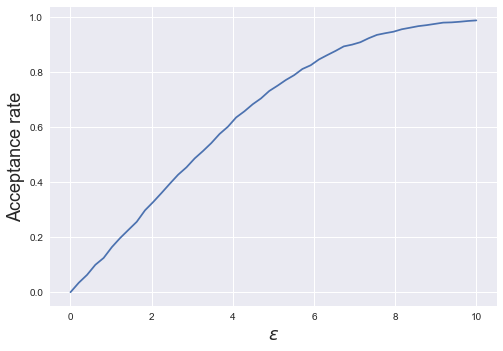

In [27]:
print(accepted_ratio)
plt.plot(epsilon_seq, accepted_ratio, '-')
plt.xlabel(r'$\epsilon$', fontsize=18)
plt.ylabel('Acceptance rate', fontsize=18)
plt.show()

In [28]:
print(epsilon_seq)

[  0.           0.20408163   0.40816327   0.6122449    0.81632653
   1.02040816   1.2244898    1.42857143   1.63265306   1.83673469
   2.04081633   2.24489796   2.44897959   2.65306122   2.85714286
   3.06122449   3.26530612   3.46938776   3.67346939   3.87755102
   4.08163265   4.28571429   4.48979592   4.69387755   4.89795918
   5.10204082   5.30612245   5.51020408   5.71428571   5.91836735
   6.12244898   6.32653061   6.53061224   6.73469388   6.93877551
   7.14285714   7.34693878   7.55102041   7.75510204   7.95918367
   8.16326531   8.36734694   8.57142857   8.7755102    8.97959184
   9.18367347   9.3877551    9.59183673   9.79591837  10.        ]
